In [ ]:
!pip install python-mnist
from __future__ import print_function
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time, torch
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading & Preprocessing

In [ ]:
def data_prepare():
  """
  this function loads the mnist data, normalizes pixel values, converts labels to one hot encoding & returns the data
  """
  
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  print("Training data", x_train.shape, "Test data:", x_test.shape)
  
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
  
  # Normalization b/w -1 and 1
  x_train = (x_train/127.5) - 1 
  x_test = (x_test/127.5) - 1
  
  # converting output to categorical vector of dim = num_classes
  y_train = keras.utils.to_categorical(y_train)
  y_test = keras.utils.to_categorical(y_test)
  
  return x_train, y_train, x_test, y_test


In [ ]:
x_train, y_train, x_test, y_test = data_prepare()

Training data (60000, 28, 28) Test data: (10000, 28, 28)
Input shape for CNN of x & y of training (60000, 28, 28, 1) (60000, 10) & test data (10000, 28, 28, 1) (10000, 10)


In [ ]:
batch_size = 128
num_classes = 10
epochs = 50
img_shape = (x_train.shape[1], x_train.shape[2], 1)

#This is the input dimension for gan
latent_dim = 50


## Setting up Generator

In [ ]:
def generator():
  """
  This function returns a generator model framework based on CNN
  """
  model_gen = Sequential()

  # An input of 50 dimension is given to the Dense layer, the weights are initialized with 'he normal' (based on fan_in)
  model_gen.add(Dense(7*7*128, input_dim = latent_dim, kernel_initializer = tf.keras.initializers.he_normal(seed = 2)))
  #Leaky ReLU addresses the problem of dead gradients with ReLU and therefore is used
  model_gen.add(LeakyReLU(alpha=0.2))
  model_gen.add(Reshape((7, 7, 128)))

  #Doubling the x and y size
  model_gen.add(UpSampling2D())
  #He normal initialisation is observed to work well with Leaky ReLU activations
  model_gen.add(Conv2D(128, kernel_size=(3,3),  kernel_initializer= tf.keras.initializers.he_normal(seed = 2), padding ='same'))
  #Leaky ReLU is found to be a best practice for GAN
  model_gen.add(LeakyReLU(alpha=0.2))
  model_gen.add(UpSampling2D())
  model_gen.add(Conv2D(64, (3, 3), kernel_initializer= tf.keras.initializers.he_normal(seed = 2), padding = 'same'))
  model_gen.add(LeakyReLU(alpha=0.2))

  #Gives output of size 28*28 with one channel
  model_gen.add(Conv2D(1, kernel_size=(3,3), padding="same"))

  #makes elementwise output between -1 to 1
  model_gen.add(Activation("tanh"))
  #Adam optimizer is found to work well for generator
  model_gen.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5))
  return model_gen
g = generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              319872    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0

## Setting up Discriminator

In [ ]:
def discriminator():
  """
  This function returns a discriminator classification model framework based on CNN 
  """
  model_dis = Sequential()

  #64 kernels with size (3,3) will be employed, zero padding is kept so output size same as input size
  model_dis.add(Conv2D(128, kernel_size= (3, 3), strides = (2, 2), padding = 'same', input_shape = img_shape))
  model_dis.add(LeakyReLU(alpha=0.2))
  #dropout helps avoid overfitting
  model_dis.add(Dropout(0.3))

  model_dis.add(Conv2D(64, kernel_size= (3, 3), strides = (2, 2), padding = 'same'))
  model_dis.add(LeakyReLU(alpha=0.2))
  model_dis.add(Dropout(0.3))

  model_dis.add(Conv2D(32, kernel_size= (3, 3), strides = (2, 2), padding = 'same'))
  model_dis.add(LeakyReLU(alpha=0.2))
  model_dis.add(Dropout(0.3))

  #output is converted into 1d tensor by serially arranging all elements
  model_dis.add(Flatten())

  #sigmoid ensures output to be between 0 and 1
  model_dis.add(Dense(1, activation = 'sigmoid'))
  model_dis.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5), metrics = ['accuracy'])

  return model_dis

d = discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)         

## Combining Generator and Discriminator

In [ ]:
def gan(generator, discriminator):
  """
  This function integrates the generator and discriminator framework into a sequence and then returns a model framework
  """
  # We will train generator and discriminator sequentially and not parallely. We train discriminator and then we fix its weight and train generator
  discriminator.trainable = False
  # Creating a placeholder for the input of gan which would be a random vector of 50 dimensions
  gan_input = Input(shape =(latent_dim,))
  # The image generated from the generator, which is then fed to discriminator 
  gen_img = generator(gan_input)
  gan_output = discriminator(gen_img)

  gan_model = Model(inputs = gan_input, outputs = gan_output)
  gan_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5))
  return gan_model

gan_mod = gan(g, d)
gan_mod.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         541825    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 94049     
Total params: 635,874
Trainable params: 541,825
Non-trainable params: 94,049
_________________________________________________________________


In [ ]:
def plot_images(epoch, generator, n_samples = 50, dim = (5, 10), figsize = (10, 10), latent_dim = 50):
  """
  This function plots images generated using noise, it also saves the plots and the models for future use 
  """
  # generating random noise
  noise = np.random.normal(0, 1, size = [n_samples, latent_dim]) 
  #generating images from the noise using generator
  gen_imgs = generator.predict(noise)
  gen_imgs = gen_imgs.reshape((n_samples, 28, 28))
  plt.figure(figsize = figsize)
  for i in range(n_samples):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_imgs[i], cmap = 'gray_r', interpolation='nearest')
    plt.axis("off")
  plt.tight_layout()
  figname = 'gan_generated_image%d.png' %epoch
  plt.savefig(figname)
  filename = 'generator_model_%03d.h5' %epoch
  generator.save(filename)

In [ ]:
def training_gan(epochs = 2, batch_size = 128):
  """
  This function trains the gan framework, by training discriminator and generator sequentially
  """
  x_train, y_train, x_test, y_test = data_prepare()
  g = generator()
  d = discriminator()
  gan_mod = gan(g, d)
  batch_count = int(x_train.shape[0]/batch_size)
  for e in range(1, epochs + 1):
    print("Epoch", e)
    for _ in range(batch_count):
      #generating random noise vector and passing it as input to generator for generating image
      noise = np.random.normal(0, 1, size = [batch_size, latent_dim])
      gen_imgs = g.predict(noise)
      # Real images taken randomly
      indexes = np.random.randint(0, x_train.shape[0], size = batch_size)
      real_imgs = x_train[indexes] 
      #concatenating real and generated images and making labels for them
      training_imgs = np.concatenate([real_imgs, gen_imgs])
      y_batch = np.zeros(2*batch_size)
      y_batch[:batch_size] = 1
      d.trainable = True
      #Training the discriminator only
      d.train_on_batch(training_imgs, y_batch)
      
      #Tricking by labeling the noisy data as real data 
      noise = np.random.normal(0, 1, size= [batch_size, latent_dim])
      y_gen = np.ones(batch_size)

      # Training generator by fixing discriminator
      d.trainable = False
      gan_mod.train_on_batch(noise, y_gen)
    if(e==1 or e%10 == 0):
      plot_images(e, g)


Training data (60000, 28, 28) Test data: (10000, 28, 28)
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


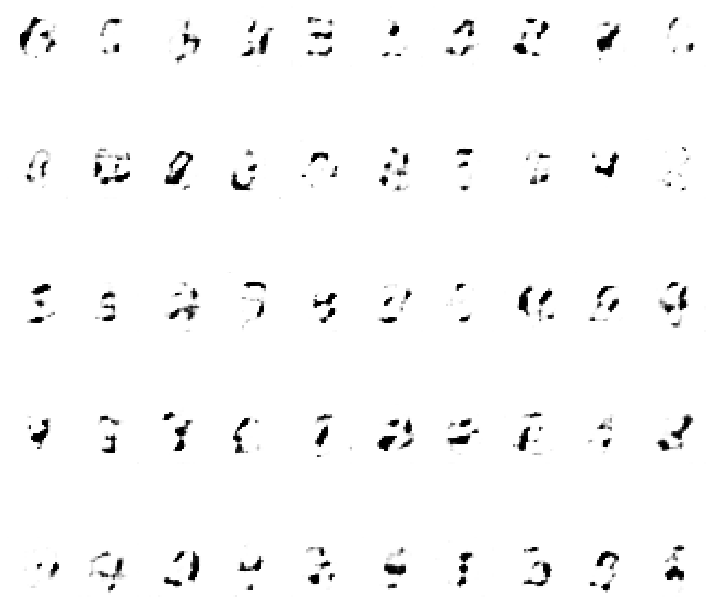

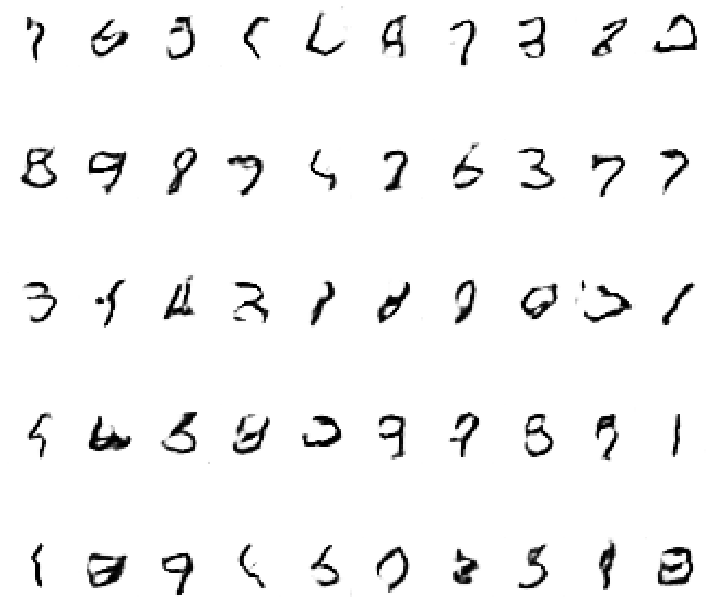

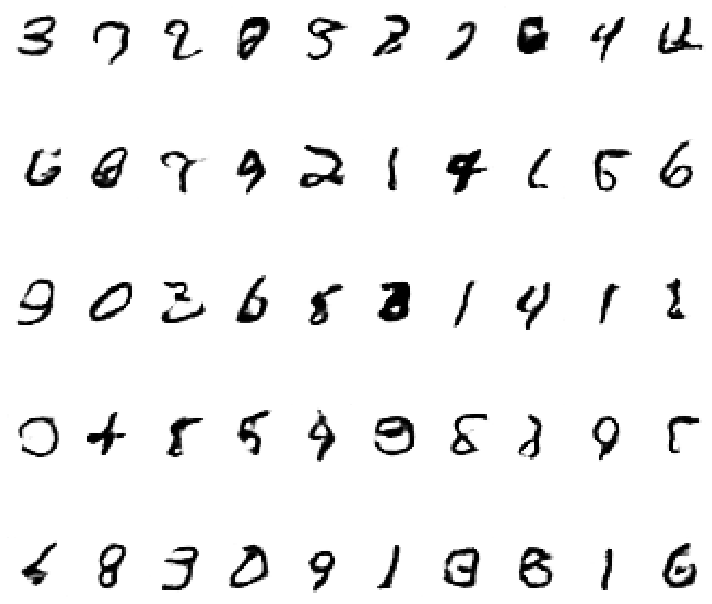

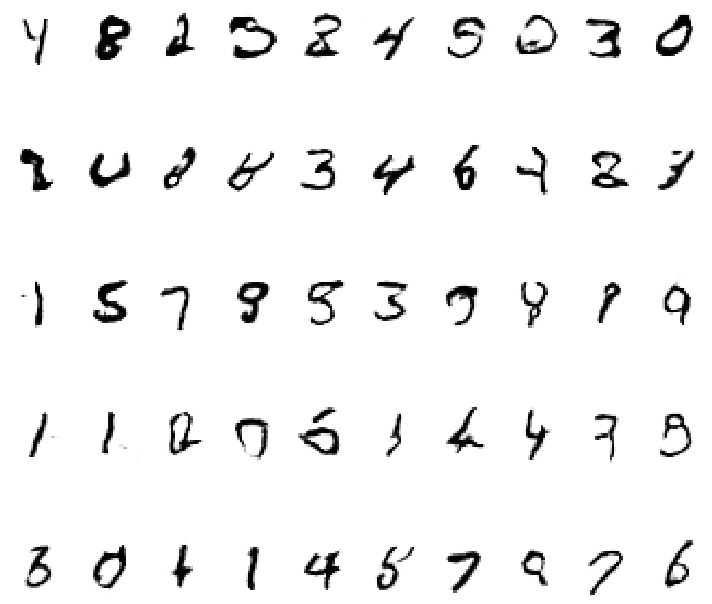

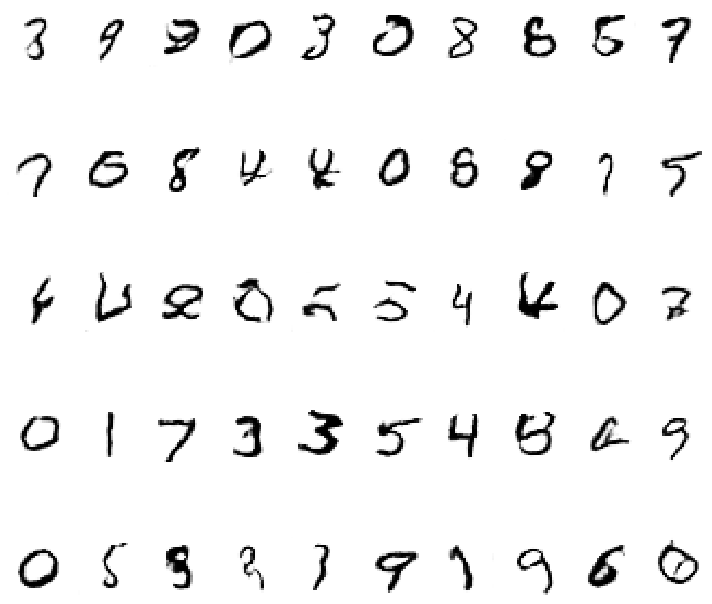

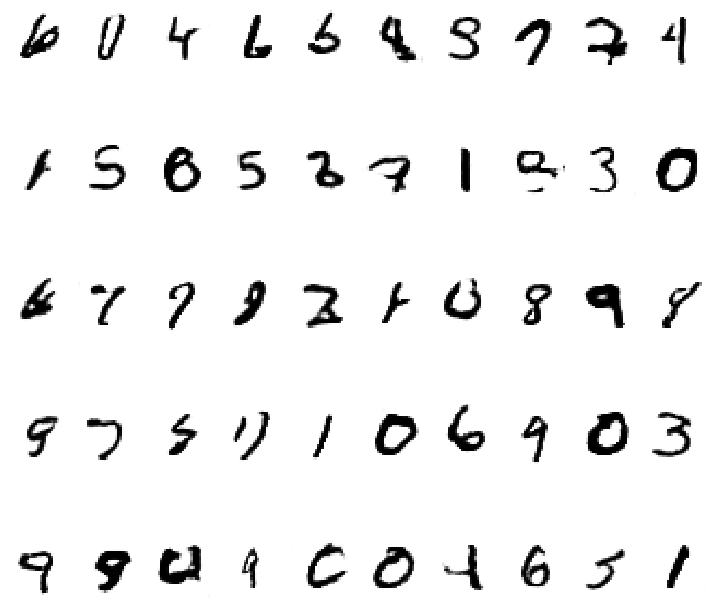

In [ ]:
#Trains gan for 50 epochs with a batch size of 128 and print the resultant images
training_gan(50, 128)

#Note: Please check the images saved in colab files after the first epoch, if they are almost blank and/or same then please re-run this block once or twice.